# GLOVe-Logistic Regression
- Uses logistic regression on GloVe embedding representation of tweets

In [13]:
## IMPORTS
# GLOVE Embeddings
import spacy

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

# GLOVE Embeddings
import spacy

# Preprocessing
import csv
import chardet
import numpy as np
import re
import pandas as pd
import demoji
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import json

# metrics
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/walnuts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# Load the dataset / read csv
# MAKE SURE CSV IS IN UTF-8 (if tweets have emojis)

## Testing if csv can open (Use for troubleshooting)
# with open('Eng_Tweets.csv') as csv_file:
#   csvFile = csv.reader(csv_file, delimiter=',')
#   for row in csv_file:
#     print(row)

LANG = 2 # 1 = English | 2 = Tagalog

pd.set_option('display.max_colwidth', None)
csv_path = 'Eng_Tweets.csv' if LANG == 1 else 'Tag_Tweets.csv'


df = pd.read_csv(csv_path)
print("total rows: " + str(len(df)))
df.head() ## head won't show emojis unless using print function

total rows: 1640


,Username,Tweet,Date posted,Label
0,@Maymay,Nung bata ako may mga ganito akong notebook na puro artista ang mukha tapos nasa isip “ano kaya pakiramdam na andyan yun mukha ko? “ Pero ngayon di ko na kailangan isipin yun.. dahil tinupad nyo ang pakiramdam na yun. Maraming salamat po Sa inyong lahat. https://t.co/DySM14tqUs,05/30/19,0.0
1,@alwaysVIRGO,"Di muna masyado makapag dutdut ngayon sobrang sama talaga pakiramdam ko, pero mag-aambag parin\r\n\r\nKAIREN TEENTASTIC https://t.co/IOYRfUt0sD",09/10/24,0.0
2,@𝐣𝐚𝐢 ˙𐃷˙ ˙˚°✰,So anong pakiramdam na may picture kayo sa cellphone ni Junkyu? 🙇🏻‍♀️ https://t.co/zygW8j3Gia,09/09/24,0.0
3,@🌷 Turon Ng SM 🌷,"panay siksik, alam naman ng masama pakiramdam ng daddy 🥴🤧😷🤒 https://t.co/UtRYLGdCms",09/10/24,0.0
4,@ₐₛₜᵣₒ,Eto yung pinaka ayaw kong pakiramdam ngayon pero wala may mood talaga tayong gusto lang natin magpahinga,09/05/24,1.0


In [21]:
df['Label'].value_counts()

Label
0.0    1139
1.0     495
Name: count, dtype: int64

## Preprocessing
- Remove mentions (@)
- Remove hashtags (#)
- Remove URLs
- Replace emojis with textual description (Using demoji)
- Remove stop words

In [22]:
### PREPROCESSING STEPS (FOR TAGALOG)
with open('tl_stopwords.json', 'r') as f:
    tagalog_stop_words = json.load(f)

# Preprocessing functions
def clean_text_tl(text):
    # Remove mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Replace emoji with textual descriptions
    text = demoji.replace_with_desc(text)
    text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text)  # Add spaces around the shortcode
    text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
    text = text.strip()
    return text

def remove_stopwords_tl(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in tagalog_stop_words]
    return ' '.join(filtered_words)

In [5]:
### PREPROCESSING STEPS
def clean_text(text):
  # Remove mentions
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  # Remove hashtags
  text = re.sub(r'#\w+', '', text)
  # Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  # Replace emoji with textual descriptions
  text = demoji.replace_with_desc(text)
  text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text) # Add spaces around the shortcode
  text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
  text = text.strip()
  return text

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

In [6]:
## Execute preprocessing
df = df.dropna()  # Get rid of NaN rows

if LANG == 1:
    print("EXECUTING TAGALOG TWEET CLEANING")
    df['Tweet'] = df['Tweet'].apply(clean_text_tl)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords_tl)
else:
    print("EXECUTING ENGLISH TWEET CLEANING")
    df['Tweet'] = df['Tweet'].apply(clean_text)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords)

df.head()

,Username,Tweet,Date posted,Label
0,@fudaishii,i'm genuinely going attempt tonight can't anymore can't handle stress wish never born bro,9/11/24,1.0
1,@yourdystiny,"Becoming less reactive huge part growth & decreasing stress. let everything get worked up, you’ll damage mind, body & spirit.",9/8/24,0.0
2,@ocenhxu,??? tired ??? stressed ??? exhausted ??? wanna cry ??? yes.,9/8/24,1.0
3,@ifeelgoodto,"skipping meals, irregular sleeping habits, overthinking, stress, tired drained. that's me, that's everyday life",9/10/24,0.0
4,@ysuckme,"deserve happy. confused, hurt, stressed, happy.",9/8/24,0.0


In [7]:
df['Label'].value_counts()

Label
0.0    1837
1.0     496
Name: count, dtype: int64

## GloVe Embeddings
- Make sure to run "python -m spacy download en_core_web_md"
- GloVe embeddings are then averaged and standardized
- Train-Test-Validation split = 70% - 20% - 10%
- Uses undersampling to balance the training set
- Uses standard scaler for standardization of values

In [23]:
nlp = spacy.load("en_core_web_md", disable=["tagger", "parser", "ner"]) # disable non word-embedding parts of spacy

# Create an empty list to store the embeddings
embeddings = []

# Iterate through the DataFrame
for index, row in df.iterrows():
    tweet = row['Tweet']
    doc = nlp(tweet)

    # Get the embeddings for each token and store them
    tweet_embeddings = [token.vector for token in doc]
    embeddings.append(tweet_embeddings)

# Add the embeddings to the DataFrame as a new column
df['embeddings'] = embeddings

/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [26]:
# Function to average embeddings for a tweet
def average_embeddings(embeddings_list):
    if embeddings_list:
        return np.mean(embeddings_list, axis=0)
    else:
        return np.zeros(300)  # 300 = embedding dimenstion

In [27]:
# Function to split the dataset into train, validation, and test
def split_data(df, train_size=0.7, val_size=0.1, test_size=0.2):
    # 70% into training 30% into validation + testing 
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=42)
    
    # 30% splits 10% into validation and 20% into testing
    val_df, test_df = train_test_split(temp_df, train_size=val_size / (val_size + test_size), random_state=42)
    
    return train_df, val_df, test_df

In [28]:
## WITH IMBALANCED DATASET
# Average the sentence embedding into a single entry
df['avg_embedding'] = df['embeddings'].apply(average_embeddings)

# Split the dataset
train_df, val_df, test_df = split_data(df)

X_train = np.array(train_df['avg_embedding'].to_list())
y_train = train_df['Label']
X_val = np.array(val_df['avg_embedding'].to_list())
y_val = val_df['Label']
X_test = np.array(test_df['avg_embedding'].to_list())
y_test = test_df['Label']

## PICK ONE OF THESE
# Undersample the training set to balance the classes
# undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)  # balances classes
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Oversample the training set to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Optionally, check the class distribution after undersampling
print(f"Class distribution after undersampling:\n{pd.Series(y_train_resampled).value_counts()}")

# Standardization
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)  # Apply scaling to the resampled data
X_test = scaler.transform(X_test)  # Apply scaling to the test data
X_val = scaler.transform(X_val)  # Apply scaling to the validation data

Class distribution after undersampling:
Label
1.0    801
0.0    801
Name: count, dtype: int64


## Logistic Regression

In [29]:
# Train and evaluate logistic regression with validation
model = LogisticRegression(max_iter = 1000)
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

## Metrics
- Validation set
    - Accuracy
    - Precision
    - Recall
    - F1 Score
    - Balanced Accuracy
    - Confusion Matrix
- Test Set
    - Accuracy
    - Precision
    - Recall
    - F1 Score
    - Balanced Accuracy
    - Confusion Matrix
- ROC AUC

Validation Accuracy: 0.8282208588957055
Validation Precision: 0.6170212765957447
Validation Recall: 0.7435897435897436
Validation F1 Score: 0.6744186046511628
Validation Balanced Accuracy: 0.7992142266335815
Validation Confusion Matrix: 
[[106  18]
 [ 10  29]]
Test Accuracy: 0.7828746177370031
Test Precision: 0.7019230769230769
Test Recall: 0.6460176991150443
Test F1 Score: 0.6728110599078341
Test Balanced Accuracy: 0.7505789430154661
Test Confusion Matrix: 
[[183  31]
 [ 40  73]]
Test ROC AUC: 0.8306591679761806


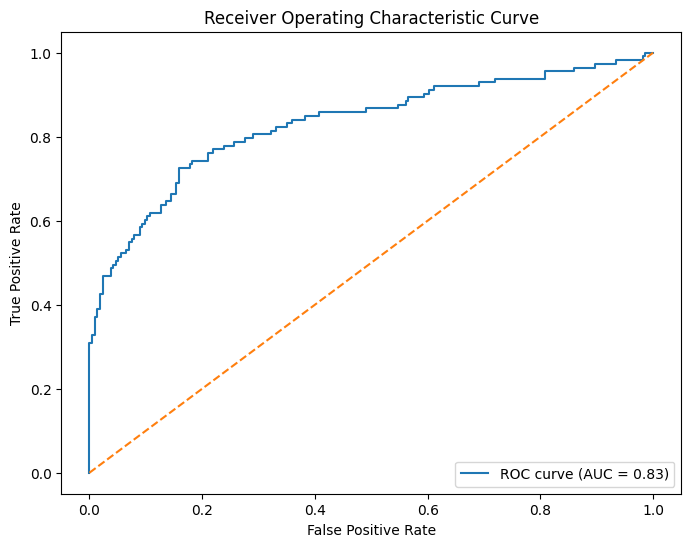

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Evaluation on validation set
y_pred_val = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
balanced_acc_val = balanced_accuracy_score(y_val, y_pred_val)  # Add balanced accuracy
conf_matrix_val = confusion_matrix(y_val, y_pred_val)

print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1 Score: {f1_val}")
print(f"Validation Balanced Accuracy: {balanced_acc_val}")  # Print balanced accuracy
print(f"Validation Confusion Matrix: \n{conf_matrix_val}")

# Final evaluation on test set
y_pred_test = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
balanced_acc_test = balanced_accuracy_score(y_test, y_pred_test)  # Add balanced accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test Balanced Accuracy: {balanced_acc_test}")  # Print balanced accuracy
print(f"Test Confusion Matrix: \n{conf_matrix_test}")

# Compute ROC AUC
y_prob_test = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_prob_test)
print(f"Test ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()


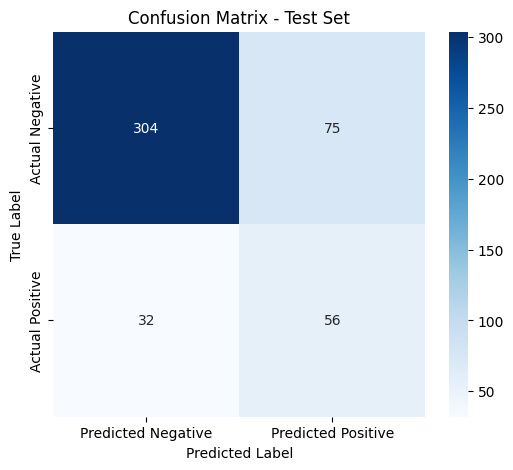

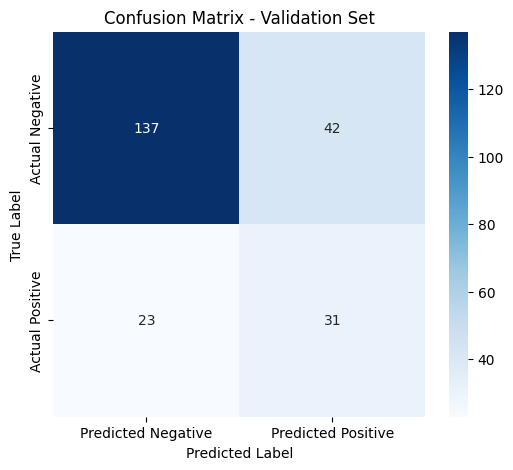

In [14]:
# Plot confusion matrix for test set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Final Training Score: 0.9438
Final Cross-validation Score: 0.8783


/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklear

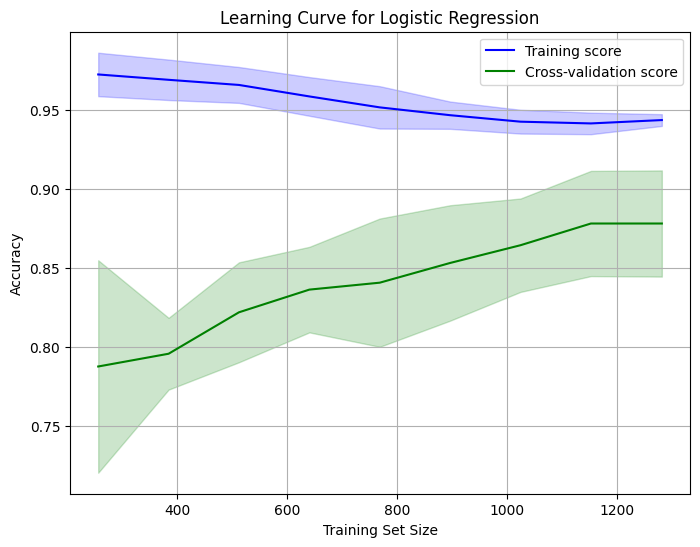

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming you have already defined and resampled your data
# X_train_resampled and y_train_resampled should be your training data and target

# Initialize StratifiedKFold with 5 splits
stratified_cv = StratifiedKFold(n_splits=5)

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_resampled, y_train_resampled, cv=stratified_cv,  # Use StratifiedKFold
    scoring='accuracy',  # Score using accuracy
    train_sizes=np.linspace(0.1, 1.0, 10),  # Training sizes from 10% to 100%
    n_jobs=-1  # Parallel processing
)

# Calculate the mean and standard deviation of train and test scores
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

# Print the final scores (for the largest training set size)
print(f"Final Training Score: {train_scores_mean[-1]:.4f}")
print(f"Final Cross-validation Score: {test_scores_mean[-1]:.4f}")

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='green')

# Fill the area between the curve and the axis to represent the standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.2)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Logistic Regression')
plt.legend(loc='best')
plt.grid(True)
plt.show()
